# Поведение пользователей мобильного приложения

**Описание проекта**:

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента: дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. 

Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

**Задачи проекта**:

 - Выявить полные данные из таблицы
 - Изучить воронку событий
 
  1) Какие события есть в логах и как часто они встречаются;
  
  2) Сколько пользователей совершало то или иное событие;
  
  
 - Изучить результаты эксперемента по изменению шрифта
  
  1) Есть ли разница в статистических критериях между выборками в группах 246 и 247; 
  
  2) Есть ли разница в статистических критериях между выборками в группах 246 и 248;  
  
  3) Есть ли разница в статистических критериях между выборками в группах 247 и 248; 
  
  4) Есть ли разница в статистических критериях между выборками в объединённой контрольной группе и 248 группой; 
  
  
 - Сделать выводы по изменению шрифта.

## Знакомство с информацией и подготовка данных к обработке

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import math as mth
from scipy import stats as st

In [2]:
# Напишем функцию для изменения столбца с датой
custom_date_parser = lambda x: pd.to_datetime (x, unit='s') 
#откроем таблицу hypothesis и выведем её на экран
logs = pd.read_csv ('/datasets/logs_exp.csv', sep = '\t', parse_dates = ['EventTimestamp'], date_parser = custom_date_parser)
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [3]:
# Просмотрим основную информацию по данной таблице
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null datetime64[ns]
ExpId             244126 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


Нет пропущенных значений.

В таблице 244126 строк и 4 столбца:

 - 	EventName — название события;
 - 	DeviceIDHash — уникальный идентификатор пользователя;
 - 	EventTimestamp — время события;
 - 	ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная

In [4]:
# Проверим таблицу на дубликаты
print('Всего в таблице', logs.duplicated().sum(), 'дубликатов')
print('Это всего {:.2%} от общего количества, так что спокойно их удаляем'.format(logs.duplicated().sum() / len(logs)))

Всего в таблице 413 дубликатов
Это всего 0.17% от общего количества, так что спокойно их удаляем


In [5]:
# удаление всех дубликатов
logs=logs.drop_duplicates().reset_index(drop=True)

In [6]:
# Переименуем наши столбцы
logs = logs.rename(columns={'EventName': 'name', 'DeviceIDHash': 'id', 'EventTimestamp': 'data_time', 'ExpId': 'group'})
                                   
# Создадим отдельный столбец с датой
logs['data'] = logs['data_time'].dt.date

### Вывод

Я выгрузила таблицу
В ней нет пропущенных значений.

В таблице 244126 строк и 4 столбца:

    EventName — название события;
    DeviceIDHash — уникальный идентификатор пользователя;
    EventTimestamp — время события;
    ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная

Также были дубликаты, я их удалила.
Подготовила таблицу к дальнейшей обработке. Изменила название столбцов, привела стобец с датой и временем к читаемому виду, и также вывела отдельный столбец с датой.

## Изучение и проверка данных

###  Сколько всего событий в логе?

In [7]:
print('Всего событий', len(logs['name']))

Всего событий 243713


###  Сколько всего пользователей в логе?

In [8]:
print('Всего пользователей', logs['id'].nunique())

Всего пользователей 7551


### Сколько в среднем событий приходится на пользователя

In [9]:
# Создадим группировкой таблицу по клиентам выведем медиану
logs.groupby('id').agg({'name': 'count'}).median()
print('В среднем на одного пользователя выходит {} событий'.format(int(logs.groupby('id').agg({'name': 'count'}).median())))

В среднем на одного пользователя выходит 20 событий


### Период данных

In [10]:
# Посмотрим минимальную и максимальную дату
print('Минимальный дата в нашей таблице', logs['data'].min())
print('Максимальная дата в нашей таблице',logs['data'].max())

Минимальный дата в нашей таблице 2019-07-25
Максимальная дата в нашей таблице 2019-08-07


В таблице мы имеем период с 25 июля до 7 августа 2019 года. Но посмотрим сколько событий приходится на тот или иной день.

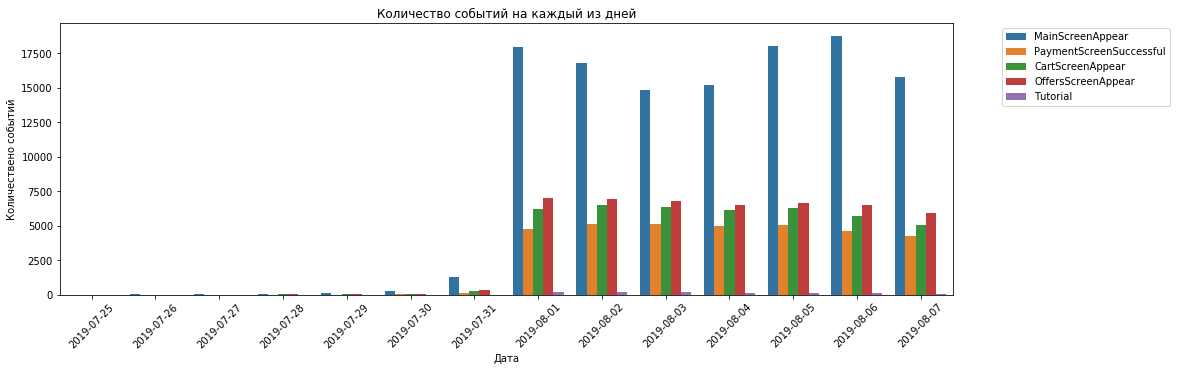

In [11]:
# Увеличим размер рисунка
plt.figure(figsize=(16, 5))

# Построим гистограмму по дате и типу события
sns.countplot(x='data', hue='name', data=logs)

# Добавим подпись к таблице, вынесем легенду за график, и развернем подписи к оси x
plt.title('Количество событий на каждый из дней')
plt.xlabel('Дата')
plt.ylabel('Количествено событий')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45);

Судя по графику, полные данные у нас начинаются с 1 августа, удалим все остальные данные из таблицы.

In [12]:
# Приведём столбец с датой к типу данный даты
logs['data'] = pd.to_datetime(logs['data'])

# обновим нашу таблицу по информации по дате
logs = logs['2019-08-01' <= logs['data']]

print(logs['data'].min())
print(logs['data'].max())

2019-08-01 00:00:00
2019-08-07 00:00:00


Итого мы располагаем информацией с 1 по 7 августа 2019 года

### Сколько данных потеряно из-за изменения периода

Посмотрим сколько у нас данных по обновлённой таблице.

In [13]:
print('Событий в логе в период с 1 по 7 августа', len(logs['name']))
print('Изначально в таблице было 243713 события, итого мы потеряли {} событий, это {:.2%}'.format(243713 - len(logs['name']), (243713 - len(logs['name'])) / 243713))
print('Количество пользователей в период с 1 по 7 августа', logs['id'].nunique())
print('Пользователей было 7551, итого мы потеряли {} пользователей, это {:.2%}'.format(7551 - logs['id'].nunique(), (7551 - logs['id'].nunique()) / 7551))

Событий в логе в период с 1 по 7 августа 240887
Изначально в таблице было 243713 события, итого мы потеряли 2826 событий, это 1.16%
Количество пользователей в период с 1 по 7 августа 7534
Пользователей было 7551, итого мы потеряли 17 пользователей, это 0.23%


### Проверка, что есть пользователи из всех трёх экспериментальных групп

In [14]:
# Посмотрим сколько сколько значений есть в столбце с группами
logs['group'].value_counts()

248    84563
246    79302
247    77022
Name: group, dtype: int64

Все три группы пользователей остались в нашей изменённой таблице.

### Вывод

Мы убрали из таблицы неполные данные, и наша таблица теперь имеет информацию с 1 по 7 августа.

При удалении неполных данных мы потеряли около 1% данных, но основные данные сохранились прежними, в нашем анализе будет присутсвовать информация по всем трём группам.

Итого в нашей таблице 240887 событий и 7534 пользователя.

## Изучение воронки событий

### Какие события есть в логах, как часто они встречаются.

In [15]:
# Посмотрим какие типы событий в нашей таблице
logs['name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: name, dtype: int64

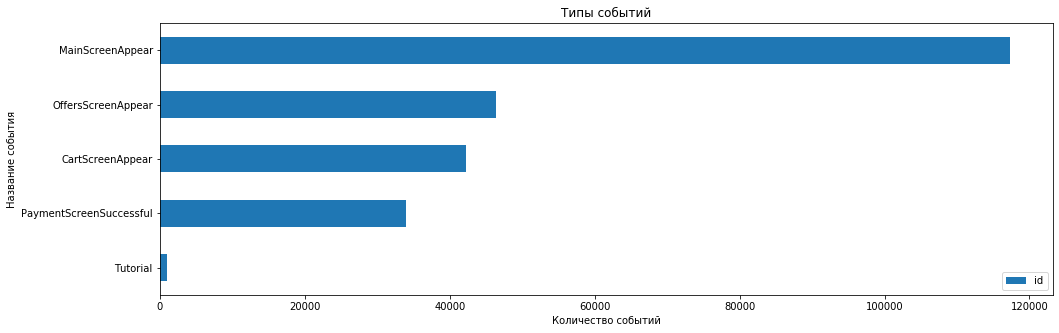

In [16]:
# Построим график по типу событий и отсортируем его по убыванию
logs.groupby('name').agg({'id': 'count'}).sort_values('id', ascending = True).plot(figsize=(16, 5), kind='barh')

# Добавим подпись к таблице, вынесем легенду за график, и развернем подписи к оси x
plt.title('Типы событий')
plt.xlabel('Количество событий')
plt.ylabel('Название события');

Всего у нас 5 событий в таблице:
 - MainScreenAppear - открыл главный экран - его совершили 117 328 раз
 - OffersScreenAppear - открыл экран предложений - его совершили 46 333 раза
 - CartScreenAppear - открыл корзину - его совершили 42 303 раза
 - PaymentScreenSuccessful - открыл экран оплаты - его совершили 33 918 раз
 - Tutorial - открыл руководство - его совершили 1 005 раз

### Сколько пользователей совершали то или иное событие.

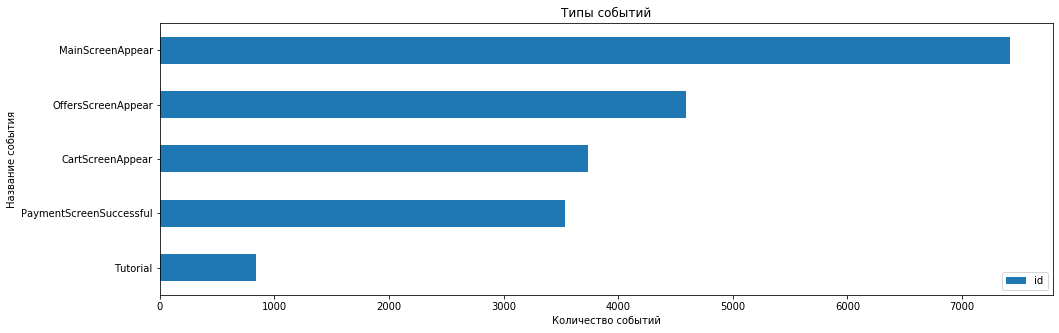

In [17]:
# Построим график по типу событий и отсортируем его по убыванию
logs.groupby('name').agg({'id': 'nunique'}).sort_values('id', ascending = True).plot(figsize=(16, 5), kind='barh')

# Добавим подпись к таблице, вынесем легенду за график, и развернем подписи к оси x
plt.title('Типы событий')
plt.xlabel('Количество событий')
plt.ylabel('Название события');

In [18]:
# Создадим новую таблицу и несколько столбцов в ней, чтобы вычислить долю пользоватлей
logs_2=logs.pivot_table(index='name', values='id', aggfunc=['nunique']).reset_index()
logs_2.columns = ['name', 'id', '123']
logs_2 = logs_2[['name', 'id']]
logs_2['all_id'] = logs['id'].nunique()
logs_2['share'] = (logs_2['id'] / logs_2['all_id'] * 100).round(1)
logs_2.sort_values('share', ascending = False)

,name,id,all_id,share
1,MainScreenAppear,7419,7534,98.5
2,OffersScreenAppear,4593,7534,61.0
0,CartScreenAppear,3734,7534,49.6
3,PaymentScreenSuccessful,3539,7534,47.0
4,Tutorial,840,7534,11.1


Событие "открытие главного экран" (MainScreenAppear) совершили 7419 клиента - это 98,5% от всех пользователей

Событие "открытие экрана предложений" (OffersScreenAppear) совершили 4593 клиента - это 61% от всех пользователей

Событие "открытие корзины" (CartScreenAppear) совершили 3434 клиента - это 49,6% от всех пользователей

Событие "открытие экрана оплаты" (PaymentScreenSuccessful) совершили 3539 клиента - это 47% от всех пользователей

Событие "открытие руководства" (Tutorial) совершили 840 клиента - это 11,1% от всех пользователей

### Предположение, в каком порядке происходят события. 

Предположим, что пользователь

 - сначала открывает главную страницу приложения(MainScreenAppear)
 - потом переходит на экран предложений(OffersScreenAppear)
 - выбирает товары и переходит в корзину(CartScreenAppear)
 - и оплачивает(PaymentScreenSuccessful)
 
 
Событие 'открытие руководства (Tutorial)' я решила не добавлять в определённую цепочку событий, т.к. слишком мало пользователей открывало руководство, и сложно предположить на каком именно этапе. 

### Построение воронки событий

In [ ]:
# Построим воронку продаж
fig = go.Figure(go.Funnel(
    y = (logs_2[(logs_2['name'] != 'Tutorial')].sort_values('id', ascending=False)['name']),
    x = (logs_2[(logs_2['name'] != 'Tutorial')].sort_values('id', ascending=False)['id'])))

fig.show()

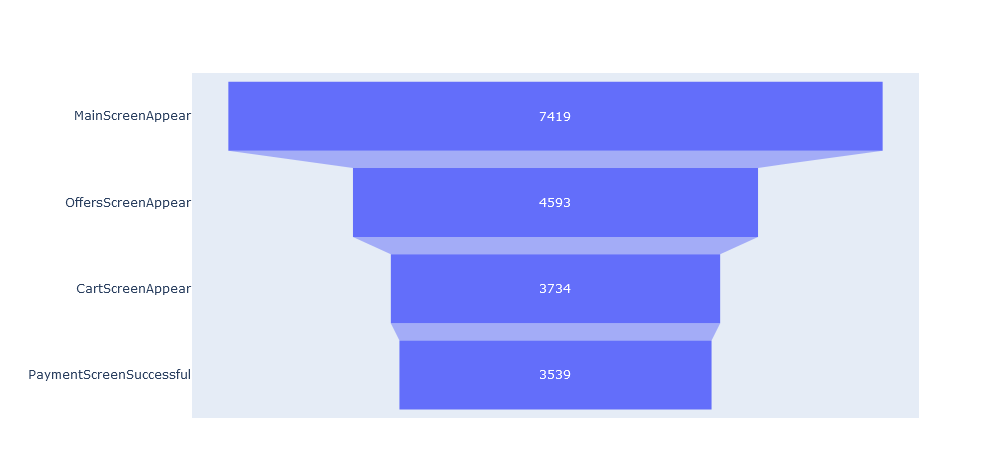

### Вывод

У нас есть 5 типов событий

 - MainScreenAppear - открытие главного экран - его совершили 7419 клиентов 117 328 раз
 - OffersScreenAppear - открытие экрана предложений - его совершили 4593 клиентов 46 333 раза
 - CartScreenAppear - открытие корзины - его совершили 3434 клиента 42 303 раза
 - PaymentScreenSuccessful - открытие экрана оплаты - его совершили 3539 клиент 33 918 раз
 - Tutorial - открытие руководство - его совершили 840 клиента 1 005 раз


Больше всего пользователей, а именно 38% уходят, открыв главный экран(MainScreenAppear) и даже без перехода к экрану предложений(OffersScreenAppear). 

Возможно зедсь часть клиентов, которая попала в приложение ошибочно, но процент слишком большой, скорее всего приложение не корректно работает или интерфейс основной страницы неудобен и/или некорректно отображается на части устройств.

От первого события до оплаты доходит меньше половины пользователей, а именно 47,7% пользователей

## Изучение результатов эксперимента

### Сколько пользователей в каждой экспериментальной группе

In [19]:
# Сгруппируем таблицу по группам и посчитаем уникальное количество id клиентов 
logs.groupby('group').agg({'id': 'nunique'})

,id
group,
246,2484
247,2513
248,2537


В 246 группе - 2484 человека, в 247 группу - 2513 человек, в 248 группе - 2537 человек. 

### Есть ли разница в статистических критериях между выборками 246 и 247?

In [20]:
# Создадим сводную таблицу по группам пользователей и событиям, которые они совершали
logs_3 = logs.pivot_table(index = 'name', columns = 'group', values = 'id', aggfunc = 'nunique').sort_values(246, ascending=False)

# Добавим в нашу таблицу новый столбец с объединёнными группами 246 и 247
logs_3['246+247'] = logs_3[246] + logs_3[247]
logs_3.drop(['Tutorial'], inplace = True)

# Скинем индексы
logs_3 = logs_3.reset_index()

# Также создадим ключи, чтобы по номеру группы выводилось количество клиентов в этой группе
group_id = {246: logs[logs['group']==246]['id'].nunique(),
           247: logs[logs['group']==247]['id'].nunique(),
           248: logs[logs['group']==248]['id'].nunique(),
           '246+247' : logs[(logs['group']==246) | (logs['group']==247)]['id'].nunique()}


Сформулируем нулевую и альтернативную гипотезы:

 - Нулевая гипотеза: Доли в группах одинаковые
 - Альтернативная гипотеза : Доли в группах разные
 
Наши гипотезы будем проверять с уровнем значимости статистического теста = 0.05

In [21]:
# Создадим функцию для сравнение долей в группах
def difference(group_1, group_2, alpha):
    for i in logs_3.index:
        alpha = alpha
        # сколько людей выполнило действие относительно общего количества в первой группе
        p1 = logs_3[group_1][i] / group_id[group_1]
        # сколько людей выполнило действие относительно общего количества во второй группе
        p2 = logs_3[group_2][i] / group_id[group_2]
        # сколько людей выполнило действие относительно общего количества
        p3 = ((logs_3[group_1][i] + logs_3[group_2][i]) / (group_id[group_1]+group_id[group_2]))
        # разница пропорций
        difference = p1 - p2
        # статистика в ст.отклонениях стандартного нормального распределения
        value = difference / mth.sqrt(p3 * (1-p3) * (1/group_id[group_1] + 1/ group_id[group_2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(value))) * 2
        print('Для события {} p-значение: {}'.format(logs_3['name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: доли в группах", group_1, 'и', group_2, 'разные')
        else:
            print("Не получилось отвергнуть нулевую гипотезу: доли в группах", group_1, 'и', group_2, 'одинаковые')
        print('')
        
    # И добавим также в функцию построение воронки для наглядности   
    fig = go.Figure()
    for i, group in enumerate([group_1, group_2]):
        fig.add_trace(go.Funnel(
            name = str(group),
            y = logs_3['name'],
            x = logs_3[group]))

    fig.show()

In [22]:
difference(246, 247, 0.05)

Для события MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу: доли в группах 246 и 247 одинаковые

Для события OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу: доли в группах 246 и 247 одинаковые

Для события CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу: доли в группах 246 и 247 одинаковые

Для события PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу: доли в группах 246 и 247 одинаковые



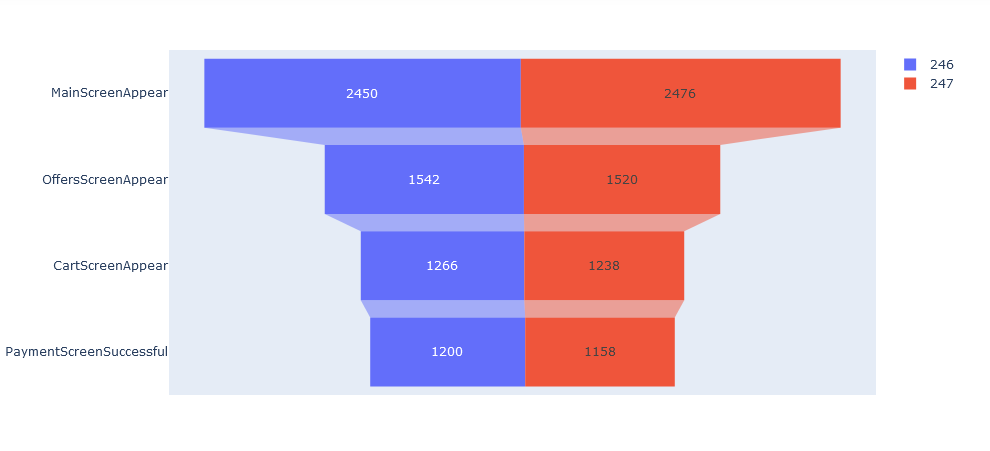

В статистических критериях между группами нет значимой разницы, так что обе группы можно считать контрольными.

### Есть ли разница в статистических критериях между выборками 246 и 248?

Наши гипотезы остаются прежними:

 - Нулевая гипотеза: Доли в группах одинаковые
 - Альтернативная гипотеза : Доли в группах разные

In [23]:
difference(246, 248, 0.05)

Для события MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу: доли в группах 246 и 248 одинаковые

Для события OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу: доли в группах 246 и 248 одинаковые

Для события CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу: доли в группах 246 и 248 одинаковые

Для события PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу: доли в группах 246 и 248 одинаковые



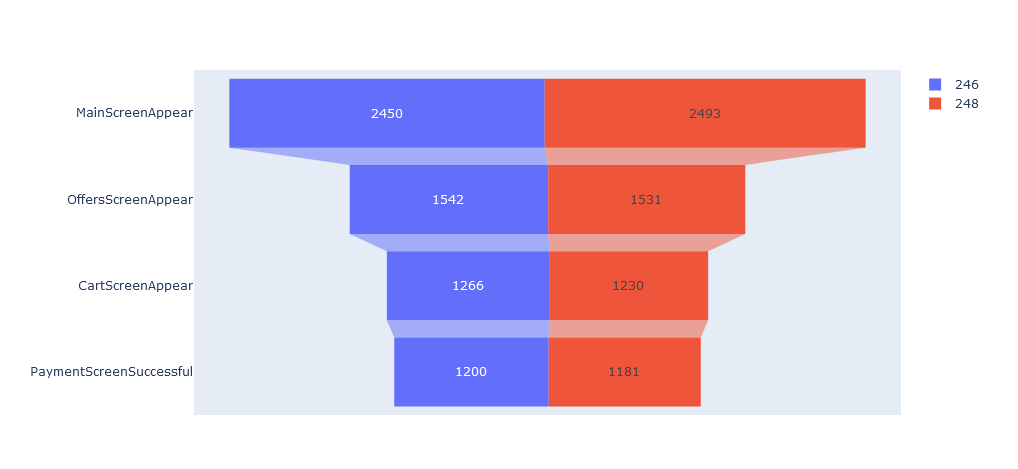

Значимой разницы между контрольной группой 246 и экспериментальной группой 248 нет.

### Есть ли разница в статистических критериях между выборками 247 и 248?

Наши гипотезы остаются прежними:

 - Нулевая гипотеза: Доли в группах одинаковые
 - Альтернативная гипотеза : Доли в группах разные

In [24]:
difference(247, 248, 0.05)

Для события MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу: доли в группах 247 и 248 одинаковые

Для события OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу: доли в группах 247 и 248 одинаковые

Для события CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу: доли в группах 247 и 248 одинаковые

Для события PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу: доли в группах 247 и 248 одинаковые



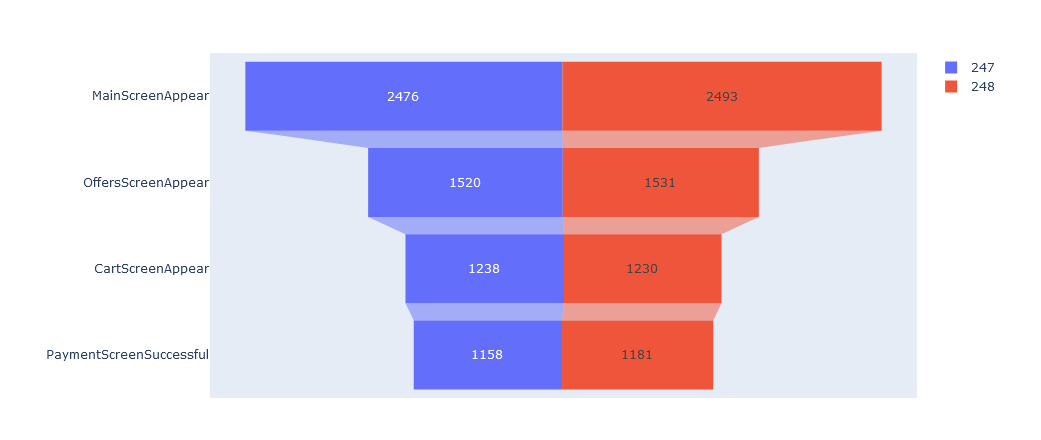

Значимой разницы между контрольной группой 247 и экспериментальной группой 248 нет.

### Есть ли разница в статистических критериях между выборками объединёнными контрольными группами и 248?

In [25]:
difference('246+247', 248, 0.05)

Для события MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу: доли в группах 246+247 и 248 одинаковые

Для события OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу: доли в группах 246+247 и 248 одинаковые

Для события CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу: доли в группах 246+247 и 248 одинаковые

Для события PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу: доли в группах 246+247 и 248 одинаковые



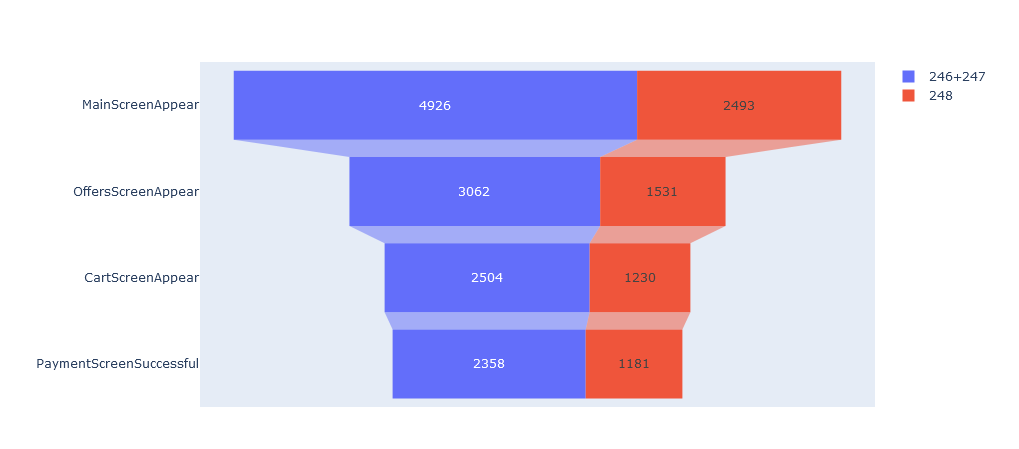

Значимой разницы между объединёнными контрольными группами (246+247) и экспериментальной группой 248 нет.

### Вывод

Изменение шрифта никак не влияет на воронку продаж.

## Вывод

В базовой таблице было 413 дублированных строк, что составило 0,17% от всей таблицы. Я их удалила.

Изначально данные в таблице были неполные. Я стала рассматривать информацию с 1 по 7 августа.

При удалении неполных данных я потеряла около 1% данных, но основные данные сохранились прежними.

Итого в таблице присутствуют 240887 событий и 7534 пользователя.

В таблице есть 5 типов событий

 - MainScreenAppear - открытие главного экран - его совершили 7419 клиентов 117 328 раз
 - OffersScreenAppear - открытие экрана предложений - его совершили 4593 клиентов 46 333 раза
 - CartScreenAppear - открытие корзины - его совершили 3434 клиента 42 303 раза
 - PaymentScreenSuccessful - открытие экрана оплаты - его совершили 3539 клиент 33 918 раз
 - Tutorial - открытие руководство - его совершили 840 клиента 1 005 раз


Больше всего пользователей, а именно 38% уходят, открыв главный экран(MainScreenAppear) и даже без перехода к экрану предложений(OffersScreenAppear). 

Возможно интерфейс основной страницы неудобен или некорректно отображается на части устройств.

От первого события до оплаты доходит меньше половины пользователей, а именно 47,7% пользователей.


Мы провели 16 проверок статистических гипотез с уровнем значимости 0.05 (12 из них проверяли разницу между контрольными группами и группой с изменённым шрифтом) и ни одна из них не выявила значимой разницы.




Я провела 16 проверок статистических гипотез с новым уровнем значимости  0.05: 4 из которых были между контрольными группами и 12 между контрольными группами и группой с изменённым шрифтом и ни одна из них не выявила значимой разницы.

При уровне значимости 0.1 одна из проверок покажет значимую разницу, между группой 246 и группой 248 в доле события  CartScreenAppear - открытие корзины, в пользу 246 группы. Но при уровне значимости 0.1 каждый десятый раз можно получать ложный результат, поэтому стоит установить уровень значимости 0.05.

Исходя из результатов данного эксперимента, я могу сделать вывод, что изменение шрифта никак не влияет на поведение клиентов. Поэтому нельзя сделать вывод какой шрифт лучше. Если с помощью изменения шрифта хотели увеличить количество клиентов, которые совершают покупки, то шрифт никак на это не повлияет.